In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from pathlib import Path

sns.set(style="whitegrid")
BASE_PATH = Path("../cache_new/optimization/")
DATASET_PATH = Path("../datasets/IDSSE/")
pio.renderers.default = "vscode"


In [61]:
def prepare_data():
    csv_files = list(BASE_PATH.rglob("*df_reduced.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        parts = file.parts[-6:]
        
        match_id = parts[0]
        step = parts[2]
        player = parts[1]
        method = parts[3]
        parameters = parts[4]

        df["game_id"] = match_id
        df["step"] = step
        df["player"] = player
        df["method"] = method
        df["parameters"] = parameters
        df["tuning"] = method + "-" + parameters

        dataframes.append(df)

    full_df = pd.concat(dataframes, ignore_index=True)
    full_df["DAS_potential_percentage"] = np.where(
        full_df["DAS_potential"] > 0,
        ((full_df["DAS"] - full_df["DAS_new"]) / full_df["DAS"]) * 100,
        0.0,
    )

    return full_df

def group_data(full_df):
    agg = (
        full_df.groupby(["game_id", "player", "step", "method", "parameters", "tuning"]).agg(
            DAS_potential=("DAS_potential", "mean"),
            MAX_DAS_potential=("DAS_potential", "max"),
            SUM_DAS_potential=("DAS_potential", "sum"),
            DAS_potential_percentage=("DAS_potential_percentage", "mean"),
            distance=("distance", "mean"),
            count=("DAS_potential", "count")
        )
        .reset_index()
    )
    cond = (
        full_df[full_df["DAS"] > 1]
        .groupby(["game_id", "player", "step", "method", "parameters", "tuning"])[["DAS_potential_percentage", "DAS_potential"]]
        .mean()
        .reset_index()
        .rename(columns={"DAS_potential_percentage": "DAS_potential_percentage_over1", "DAS_potential": "DAS_potential_over1"})
    )
    grouped_df = agg.merge(cond, on=["game_id", "player", "step", "method", "parameters", "tuning"], how="left")
    grouped_df["DAS_potential_percentage_over1"] = grouped_df["DAS_potential_percentage_over1"].fillna(0.0)
    grouped_df["DAS_potential_over1"] = grouped_df["DAS_potential_over1"].fillna(0.0)
    return grouped_df

def add_player_names():
    files = list(DATASET_PATH.rglob("*players.parquet"))
    dataframes = []
    
    for file in files:
        df = pd.read_parquet(file).copy()
        parts = file.parts
        game_id = parts[3]
        df["game_id"] = game_id
        df["team"] = "home" if "home_players" in parts[4] else "away"
        df["player"] = df['team'] + "_" + df['shirt_num'].astype(str)
        dataframes.append(df)
    
    all_players = pd.concat(dataframes, ignore_index=True)
    cols = ["game_id", "id", "full_name", "player"]
    return all_players[cols].drop_duplicates()
    
def compare_methods(fair_grouped_df):
    fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)
    
    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="DAS_potential_percentage",
                ax=axes[0]
    )
    axes[0].set_title("Boxplot DAS-Potential (%)")
    axes[0].set_ylabel("Verbesserung (%)")
    axes[0].set_xlabel("")
    axes[0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="DAS_potential",
                ax=axes[1]
    )
    axes[1].set_title("Boxplot DAS-Potential")
    axes[1].set_ylabel("Verbesserung")
    axes[1].set_xlabel("")
    axes[1].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    
    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="DAS_potential_percentage_over1",
                ax=axes[2]
    )
    axes[2].set_title("Boxplot DAS-Potential > 1 (%)")
    axes[2].set_ylabel("Verbesserung")
    axes[2].tick_params(axis="x", rotation=45)
    
    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="DAS_potential_over1",
                ax=axes[3]
    )
    axes[3].set_title("Boxplot DAS-Potential > 1")
    axes[3].set_ylabel("Verbesserung")
    axes[3].tick_params(axis="x", rotation=45)
    
    fig.suptitle("Vergleich der Methoden", fontsize=16)
    fig.tight_layout()
    plt.show()

def line_players(grouped_df, metric="DAS_potential"):
    df = grouped_df.copy()
    df["game_id"] = df["game_id"].astype(str)
    tunings = df["tuning"].unique()
    
    fig = go.Figure()
    trace_tuning = []
    
    hovertemplate = (
        "Spiel: %{x}<br>"
        f"{metric}: " + "%{y:.3f}<br>"
        "count: %{customdata}<extra></extra>"
    )
    
    for t in tunings:
        dft = df[df["tuning"] == t]
        for name, g in dft.groupby("full_name"):
            fig.add_trace(
                go.Scatter(
                    x=g["game_id"], y=g[metric],
                    mode="lines+markers",
                    name=name,
                    legendgroup=name,
                    showlegend=(t == tunings[0]),
                    customdata=g["count"].values,
                    hovertemplate=hovertemplate,
                    marker=dict(size=6),
                    line=dict(width=1)
                )
            )
            trace_tuning.append(t)
            
    buttons = []
    for t in tunings:
        visible_mask = [tt == t for tt in trace_tuning]
        buttons.append(dict(
            label=t,
            method="update",
            args=[
                {"visible": visible_mask},
                {"title": f"DAS Potential pro Spiel (Tuning: {t})"}
            ]
        ))
    initial_mask = [tt == tunings[0] for tt in trace_tuning]
    fig.update_traces(visible=False)
    for i, vis in enumerate(initial_mask):
        fig.data[i].visible = vis
        
    # fig = px.line(
    #     grouped_df,
    #     x="game_id",
    #     y="DAS_potential",
    #     color="full_name",
    #     markers=True,
    #     title="DAS Potential pro Spiel"
    # )

    
    fig.update_layout(
        title=f"DAS Potential pro Spiel (Tuning: {tunings[0]})",
        xaxis_title="Spiel",
        yaxis_title=metric,
        legend_title="Spieler",
        updatemenus=[dict(
            type="dropdown",
            x=1.1,
            y=1.15,
            xanchor="left",
            buttons=buttons,
            active=0
        )],
        hovermode="closest"
    )
    fig.show()
    
def scatter_dist_pot(grouped_df):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=grouped_df, x="distance", y="DAS_potential_percentage", hue="method")
    plt.title("Zusammenhang: Entfernung vs. Potential")
    plt.xlabel("Entfernung (m)")
    plt.ylabel("DAS_potential_percentage (%)")
    plt.tight_layout()
    plt.show()
    
def facet_grid(grouped_df):
    g = sns.FacetGrid(
        data=grouped_df,
        col="game_id",
        hue="method",
        sharey=True,
        height=4,
        aspect=1.5
    )
    g.map(sns.barplot, "player", "DAS_potential_percentage", order=sorted(grouped_df["player"].unique()), errorbar=None)
    g.add_legend()
    g.set_titles(col_template="Match: {col_name}")
    g.set_axis_labels("Spieler", "Verbesserung (%)")
    for ax in g.axes.flat:
        ax.tick_params(axis="x", rotation=45)
        
    plt.tight_layout()
    plt.show()
    

In [50]:
full_df = prepare_data()
full_df.to_csv("output/full_das.csv", index=False)
grouped_df = group_data(full_df)
grouped_df.to_csv("output/grouped_das.csv", index=False)

display(full_df.shape)
display(full_df)
display(grouped_df.shape)
display(grouped_df)


(29042, 16)

,player_id,frame,DAS,DAS_new,new_frame,DAS_potential,move_x,move_y,distance,game_id,step,player,method,parameters,tuning,DAS_potential_percentage
0,home_19,160412,0.244021,0.232751,160412_home_19_-4.00_-2.00,0.011270,-4.0,-2.0,4.472136,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,4.618358
1,home_19,160728,0.591525,0.585407,160728_home_19_-4.00_0.00,0.006118,-4.0,0.0,4.000000,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,1.034283
2,home_19,160887,1.964608,1.917561,160887_home_19_-2.00_4.00,0.047046,-2.0,4.0,4.472136,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,2.394691
3,home_19,164080,0.020754,0.020726,164080_home_19_-4.00_1.00,0.000028,-4.0,1.0,4.123106,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.135216
4,home_19,164747,0.140323,0.139291,164747_home_19_-3.00_-1.00,0.001032,-3.0,-1.0,3.162278,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.735271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29037,home_31,158123,2.387345,2.142135,158123_home_31_-1.00_-3.00,0.245209,-1.0,-3.0,3.162278,J03WN1,step125,home_31,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,10.271214
29038,home_31,159791,0.004201,0.004169,159791_home_31_4.00_-2.00,0.000031,4.0,-2.0,4.472136,J03WN1,step125,home_31,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.740253
29039,home_31,166506,0.246944,0.241663,166506_home_31_4.00_0.00,0.005282,4.0,0.0,4.000000,J03WN1,step125,home_31,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,2.138825
29040,home_31,168445,0.367376,0.363733,168445_home_31_0.00_-5.00,0.003643,0.0,-5.0,5.000000,J03WN1,step125,home_31,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.991750


(244, 14)

,game_id,player,step,method,parameters,tuning,DAS_potential,MAX_DAS_potential,SUM_DAS_potential,DAS_potential_percentage,distance,count,DAS_potential_percentage_over1,DAS_potential_over1
0,J03WMX,away_10,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.045706,1.622119,7.175787,6.164978,4.157399,157,3.150073,0.130115
1,J03WMX,away_11,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.116799,4.439813,15.651082,5.990453,4.183218,134,6.164009,0.360689
2,J03WMX,away_13,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.006929,0.035944,0.159362,3.607357,4.259150,23,0.209862,0.005968
3,J03WMX,away_2,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.136926,1.952331,21.497338,9.110195,4.149131,157,10.122403,0.402991
4,J03WMX,away_22,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.205880,3.404915,8.646974,6.005043,4.408858,42,7.996183,0.563233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,J03WR9,home_46,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.020975,0.099206,0.125850,10.998616,3.264324,6,0.372275,0.020268
240,J03WR9,home_5,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.113947,4.108052,15.268849,11.293032,4.238039,134,11.386927,0.611929
241,J03WR9,home_7,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.060233,4.258467,7.228016,8.311592,4.072808,120,4.338032,0.321813
242,J03WR9,home_8,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.048807,1.520485,6.540151,6.739138,4.187040,134,4.941708,0.242528


In [51]:
# Übersicht vorhandene databallpy_event
pivot = full_df.groupby(["game_id", "tuning"])["player"].nunique().unstack(fill_value=0).reset_index()

pivot

tuning,game_id,all_positions-R_5-S_1-D_2-N_20,all_positions_cut_1.0-R_5-S_1-D_2-N_20-C_1.0,random-R_5-S_1-D_2-N_100,random-R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_50,random_cut_1.0-R_5-S_1-D_2-N_100-C_1.0,random_cut_1.0-R_5-S_1-D_2-N_20-C_1.0,random_cut_1.0-R_5-S_1-D_2-N_50-C_1.0
0,J03WMX,1,0,1,32,1,0,0,0
1,J03WN1,1,0,1,29,1,0,0,0
2,J03WOH,1,0,1,32,1,0,0,0
3,J03WOY,1,0,1,32,1,0,0,0
4,J03WPY,1,0,1,31,1,0,0,0
5,J03WQQ,1,1,1,31,1,1,1,1
6,J03WR9,1,0,1,30,1,0,0,0


Anzahl verschiedener Parameterkombinationen: 4


'Vollständige Kombinationen: 6'

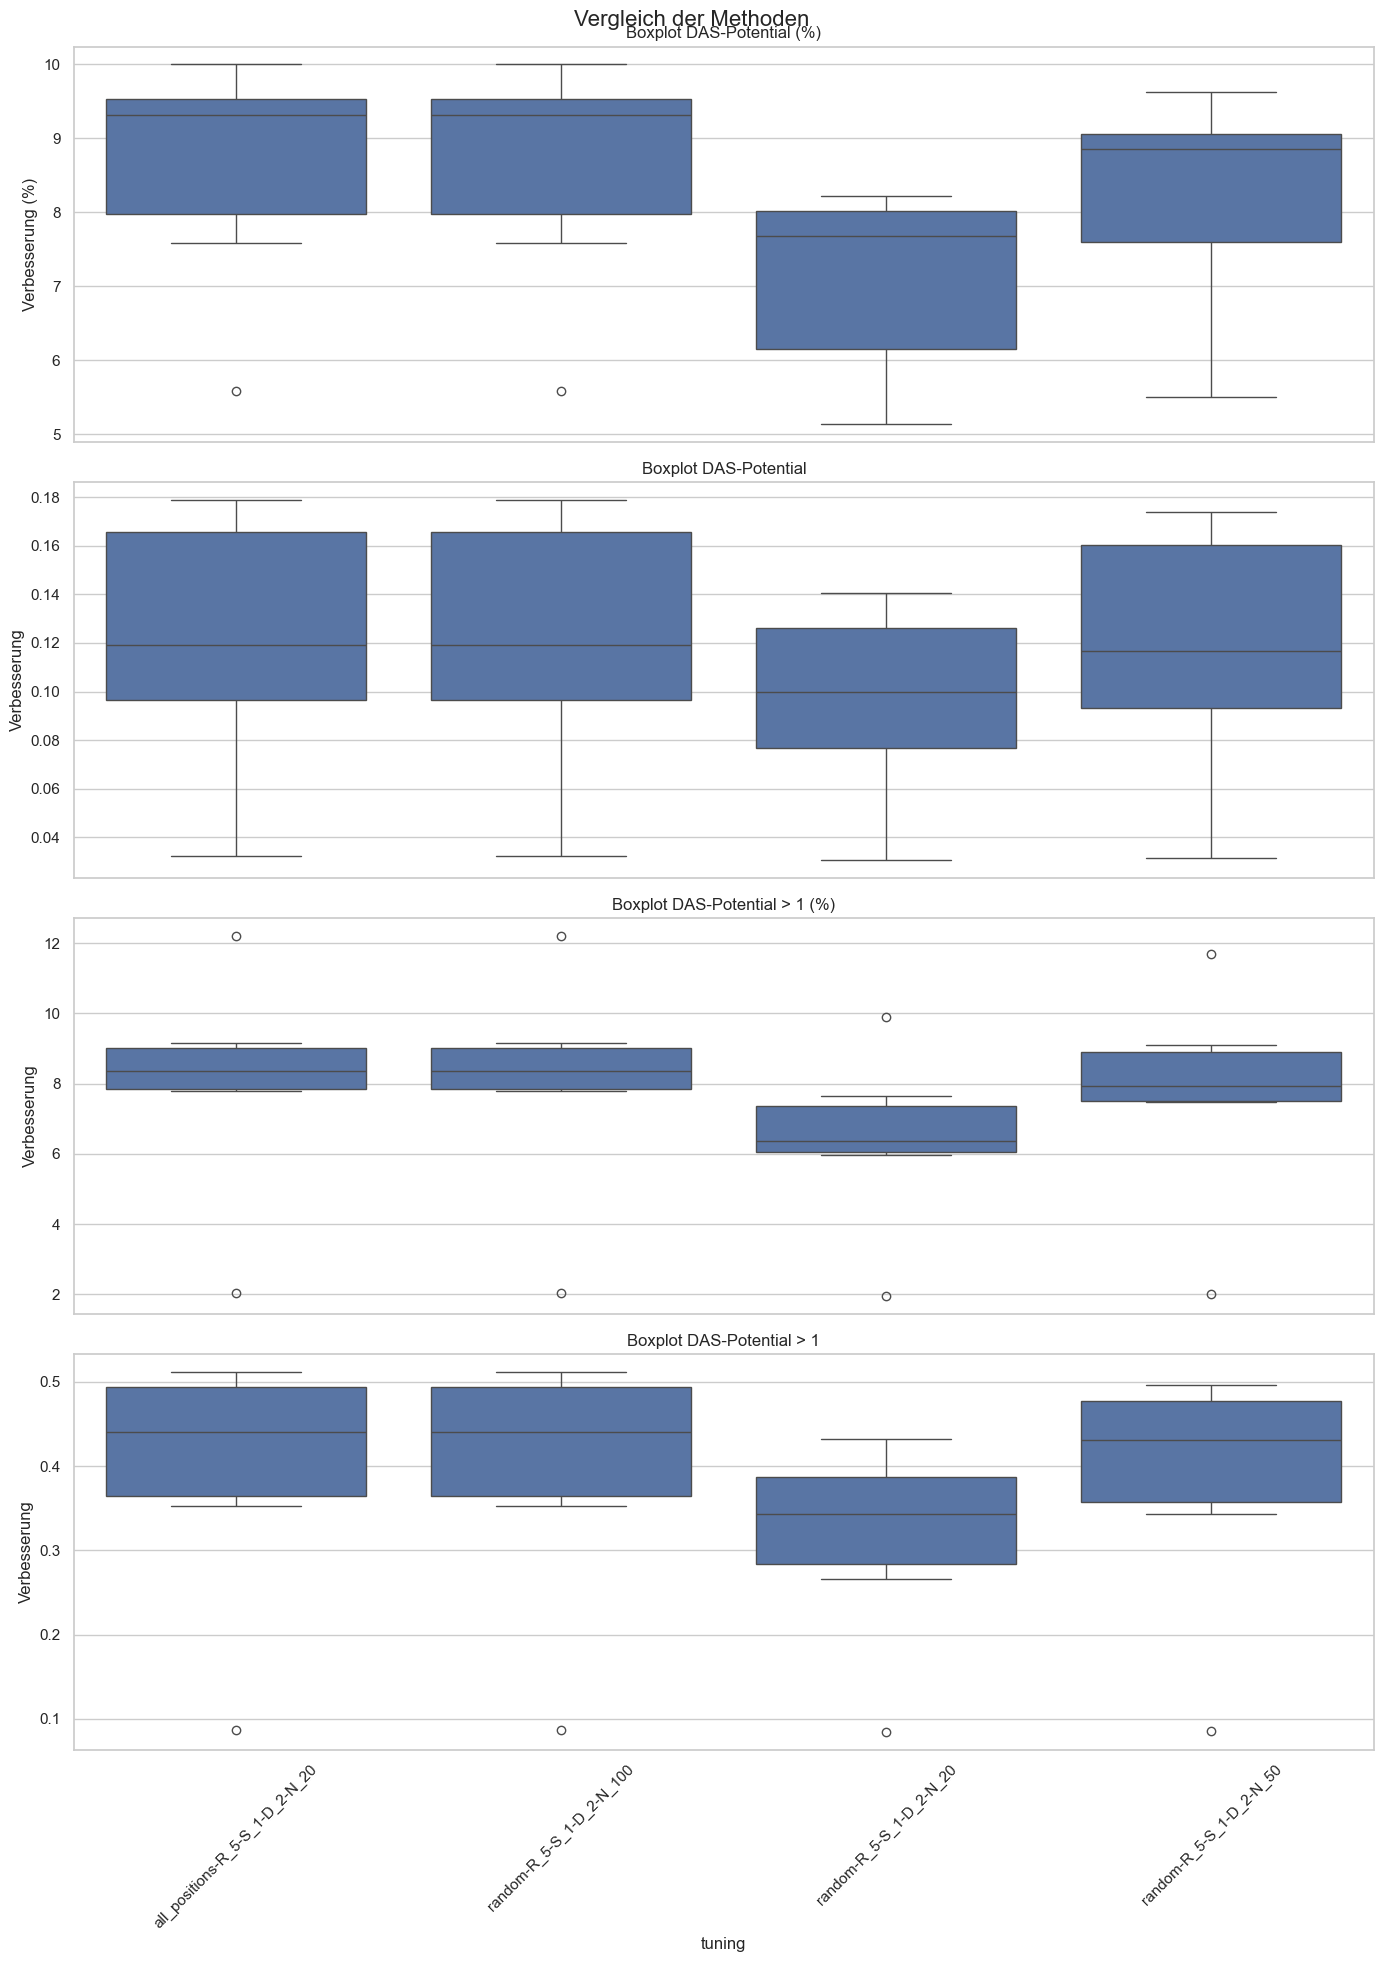

In [54]:
# Fairer Vergleich Methoden / Parameter ohne Cut STEP 125
grouped_df_125 = grouped_df[grouped_df["step"] == "step125"].copy()
mask_no_cut = ~grouped_df_125["tuning"].str.contains("cut", case=False, na=False)
grouped_no_cut = grouped_df_125[mask_no_cut].copy()
n_total_params = grouped_no_cut["tuning"].nunique()
print(f"Anzahl verschiedener Parameterkombinationen: {n_total_params}")

param_counts = (
    grouped_df.groupby(["game_id", "player"])["tuning"]
    .nunique()
    .reset_index(name="param_count")
)
complete_combinations = param_counts[param_counts["param_count"] == n_total_params]
display(f"Vollständige Kombinationen: {len(complete_combinations)}")

fair_grouped_df = grouped_df.merge(complete_combinations, on=["game_id", "player"])

compare_methods(fair_grouped_df)



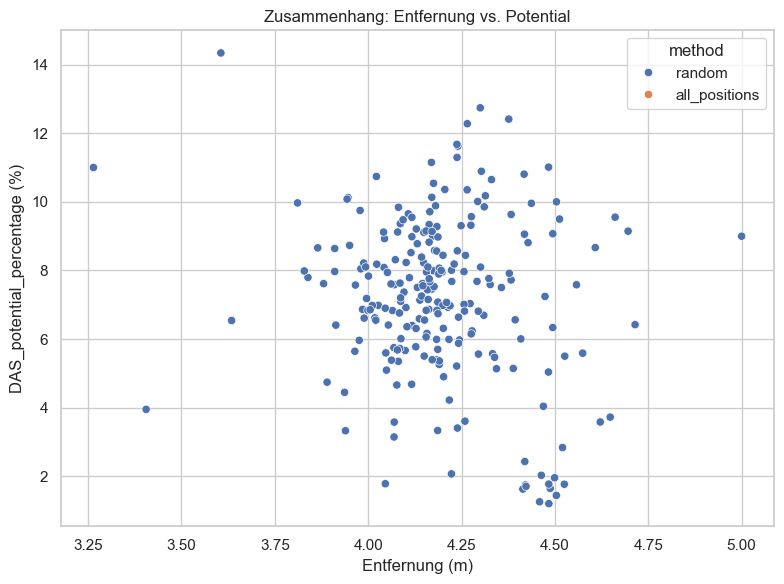

In [35]:
scatter_dist_pot(grouped_df)



In [63]:
# Spieler für alle Spiele
n_total_games = grouped_df_125["game_id"].nunique()
print(f"Anzahl Spiele: {n_total_games}")

all_players = add_player_names()
grouped_named = grouped_df_125.merge(all_players, on=["game_id", "player"], how="left")

games_played = grouped_named.groupby("id")["game_id"].nunique().reset_index(name="games_played")
n_max_games = games_played["games_played"].max()
all_game_players = games_played[games_played["games_played"] == min(n_max_games, n_total_games)]

fair_grouped_df = grouped_named.merge(all_game_players, on="id")

line_players(fair_grouped_df)
line_players(fair_grouped_df, metric="DAS_potential_percentage_over1")
line_players(fair_grouped_df, metric="DAS_potential_over1")

Anzahl Spiele: 7


In [56]:
full_df_das_g1 = full_df[full_df["DAS"] > 1]
grouped_df_das_g1 = group_data(full_df_das_g1)

grouped_named_das_g1 = grouped_df_das_g1.merge(all_players, on=["game_id", "player"], how="left")
fair_grouped_das_g1 = grouped_named_das_g1.merge(all_game_players, on="id")

line_players(fair_grouped_das_g1)
line_players(fair_grouped_das_g1, metric="MAX_DAS_potential")
